# Titre projet

In [583]:
from fredapi import Fred
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
import re
import requests

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist

from typing import List, Dict

import os

# from skfin.dataloaders.cache import CacheManager


## Récupération et préparation des données


### Données FRED

In [584]:
def load_fred_md():
    # Dataset principal
    url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
    df = pd.read_csv(url_data, index_col=0)

    # Conversion de l'index en dates si possible
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass
    
    return df

def load_transform_codes():
    url_codes = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/FRED-MD_updated_appendix.csv"
    # cp1252 (a.k.a. windows-1252) fixes the 0x92 decode error
    return pd.read_csv(url_codes, encoding="cp1252")  # or encoding="latin1"


# Chargement des deux fichiers
df = load_fred_md()
transform_codes = load_transform_codes()

C:\Users\user\AppData\Local\Temp\ipykernel_95336\551058236.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


In [585]:

# df.head(), transform_codes.head()

In [586]:
# CACHE_DIR = Path("data")
# CACHE_DIR.mkdir(parents=True, exist_ok=True)

# cm = CacheManager(cache_dir=CACHE_DIR)

# FILENAME = CACHE_DIR / "FRED_MD.parquet"

# # Sauvegarde correcte des deux DataFrames
# cm.save_to_cache(df, FILENAME)

In [587]:
print("\nTypes de données :")
print(df.dtypes)

# Vérification des doublons
n_duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {n_duplicates}")
 
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Types de données :
RPI                float64
W875RX1            float64
DPCERA3M086SBEA    float64
CMRMTSPLx          float64
RETAILx            float64
                    ...   
UMCSENTx           float64
DTCOLNVHFNM        float64
DTCTHFNM           float64
INVEST             float64
VIXCLSx            float64
Length: 126, dtype: object

Nombre de lignes dupliquées : 0

Valeurs manquantes par colonne :


CMRMTSPLx          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      2
S&P PE ratio       1
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         154
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64

Dans un premier temps, nous avons inspecté la base de données afin d’identifier la présence éventuelle de doublons ainsi que le taux de valeurs manquantes par série. 

Pour garantir un panel cohérent et exploitable en analyse factorielle et en apprentissage statistique, nous avons effectué les étapes suivantes :
- Restriction de l’échantillon à la période 1962-05 à 2025-07 : on élimine les observations trop anciennes ou trop récentes où plusieurs variables ne sont pas encore disponibles. Cela réduit l’impact des fortes valeurs manquantes en début et fin de série
- Suppression de quatre variables qui contiennent trop peu d’observations. 

In [588]:
# 1) Conversion obligatoire de l’index en datetime
df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()

cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
df = df.drop(columns=cols_to_drop, errors="ignore")
import pandas as pd
import numpy as np

df = df.loc[df.index >= "1962-05-01"].sort_index()


def trailing_nans(s: pd.Series) -> int:
    """Compte le nombre de NaN consécutifs à la fin de la série."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

nan_trails = {col: trailing_nans(df[col]) for col in df.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

print("Variables avec des NaN en fin de série :")
for var, n in nan_trails.items():
    print(f"  {var:<25} → {n} observations manquantes en bas")


# Décale de 'n' mois les séries ayant n NaN en fin de période
for col, lag in nan_trails.items():
    if lag > 0:
        df[col] = df[col].shift(lag)
        print(f"Décalage appliqué sur {col:<25} : {lag} mois")
        
df = df.dropna(how="any")

print(f"\nTaille finale du dataset : {df.shape[0]} observations, {df.shape[1]} variables")


Variables avec des NaN en fin de série :
  CMRMTSPLx                 → 1 observations manquantes en bas
  BUSINVx                   → 1 observations manquantes en bas
  ISRATIOx                  → 1 observations manquantes en bas
  NONREVSL                  → 1 observations manquantes en bas
  CONSPI                    → 1 observations manquantes en bas
  S&P div yield             → 2 observations manquantes en bas
  S&P PE ratio              → 1 observations manquantes en bas
  DTCOLNVHFNM               → 1 observations manquantes en bas
  DTCTHFNM                  → 1 observations manquantes en bas
Décalage appliqué sur CMRMTSPLx                 : 1 mois
Décalage appliqué sur BUSINVx                   : 1 mois
Décalage appliqué sur ISRATIOx                  : 1 mois
Décalage appliqué sur NONREVSL                  : 1 mois
Décalage appliqué sur CONSPI                    : 1 mois
Décalage appliqué sur S&P div yield             : 2 mois
Décalage appliqué sur S&P PE ratio              : 

C:\Users\user\AppData\Local\Temp\ipykernel_95336\4209307765.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")


La variable VIX présente deux valeurs manquantes, que nous pouvons pour le moment nous permetre de conserver puisque cette variable ne subit pas de transformation (t-code 1), ces deux variables disparaitront lorsque nous enleverons les Na apprès la transformation des autres varibales. 

A part le VIX, il ne reste plus que trois valeurs manquantes dans le dataframe, nous les remplassons par la dernière valeur connue.

In [589]:
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])
df.head()


Valeurs manquantes par colonne :


Series([], dtype: int64)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-07-01,2960.008,2769.4,17.135,293308.8034,19741.56573,25.4023,27.3468,26.2846,37.1248,23.2271,...,64.096,18.645,10.979,2.39,2.90,2.27,7242.0,16228.0,87.7873,19.5715
1962-08-01,2964.773,2772.5,17.183,291713.9599,19864.30287,25.4292,27.3468,26.2295,36.6989,22.9038,...,64.104,18.696,10.989,2.40,2.90,2.28,7344.0,16453.0,87.8828,15.7942
1962-09-01,2966.166,2775.8,17.375,298514.3889,19923.65936,25.5905,27.5190,26.3397,36.9312,23.2023,...,64.159,18.913,10.997,2.40,2.91,2.28,7442.0,16685.0,88.2080,18.3148
1962-10-01,2981.840,2785.0,17.289,293815.9271,20236.53848,25.6174,27.4329,26.3673,36.8538,23.3018,...,63.860,18.865,11.010,2.40,2.91,2.29,7407.0,16758.0,89.7636,25.9671
1962-11-01,2992.828,2798.3,17.519,299684.9733,20342.17291,25.7249,27.6050,26.4775,37.0861,23.3266,...,63.883,18.862,11.027,2.41,2.93,2.29,7453.0,16883.0,89.7457,16.7658


In [590]:
print("\nInfo générale :")
df.info()
 
print("\nStatistiques descriptives :")
display(df.describe().T)
display(df.tail())
display(df.head())


Info générale :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 1962-07-01 to 2025-08-01
Columns: 122 entries, RPI to VIXCLSx
dtypes: float64(98), int64(24)
memory usage: 727.4 KB

Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,max
RPI,757.0,10060.306425,5029.911155,2960.00800,5732.6670,8840.9180,1.387718e+04,2.291842e+04
W875RX1,757.0,8550.161691,3972.858089,2769.40000,5093.2000,7597.7000,1.171940e+04,1.673990e+04
DPCERA3M086SBEA,757.0,59.615032,30.551716,17.13500,33.0680,52.5900,8.516200e+01,1.248050e+02
CMRMTSPLx,757.0,860467.820772,377680.022390,291713.95990,524334.1780,776545.9350,1.205143e+06,1.565742e+06
RETAILx,757.0,234678.170455,190988.945647,19741.56573,66280.0710,181077.0000,3.619790e+05,7.320100e+05
...,...,...,...,...,...,...,...,...
CES3000000008,757.0,12.449696,7.152718,2.27000,5.9300,11.9000,1.841000e+01,2.903000e+01
DTCOLNVHFNM,757.0,150208.919894,146600.569198,7242.00000,14383.0000,88311.6500,2.740416e+05,5.597089e+05
DTCTHFNM,757.0,378426.503316,341198.823676,16228.00000,38156.0000,213063.0900,7.333905e+05,9.493062e+05
INVEST,757.0,1449.044971,1547.258399,87.78730,236.1659,885.6527,2.289933e+03,5.846708e+03


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
2025-04-01,20698.762,16739.9,123.748,1563633.0,721789.0,103.6224,101.3671,101.1112,101.6979,101.0930,...,106.066,119.658,131.767,32.22,36.96,28.78,554966.69,938997.88,5500.0706,32.5116
2025-05-01,20581.743,16703.7,123.575,1555663.0,716101.0,103.6570,101.4038,101.1856,101.5808,102.5239,...,106.088,119.780,132.071,32.31,37.08,28.87,554180.13,940362.47,5526.3170,20.3620
2025-06-01,20575.971,16664.7,123.894,1550522.0,723033.0,104.2115,101.7271,101.5445,101.9628,101.0181,...,106.590,120.208,132.386,32.40,37.23,28.94,551829.26,938763.49,5555.2136,18.3246
2025-07-01,20625.729,16718.9,124.370,1556845.0,727414.0,103.8194,101.4573,101.4961,101.7345,100.6594,...,106.471,120.036,132.778,32.47,37.28,29.01,549682.41,937344.92,5585.9624,16.4718
2025-08-01,20646.475,16726.7,124.805,1565742.0,732010.0,103.9203,101.5916,101.7216,102.1138,101.2996,...,106.392,120.329,133.209,32.56,37.47,29.03,547389.12,934567.19,5624.3483,15.7545


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-07-01,2960.008,2769.4,17.135,293308.8034,19741.56573,25.4023,27.3468,26.2846,37.1248,23.2271,...,64.096,18.645,10.979,2.39,2.90,2.27,7242.0,16228.0,87.7873,19.5715
1962-08-01,2964.773,2772.5,17.183,291713.9599,19864.30287,25.4292,27.3468,26.2295,36.6989,22.9038,...,64.104,18.696,10.989,2.40,2.90,2.28,7344.0,16453.0,87.8828,15.7942
1962-09-01,2966.166,2775.8,17.375,298514.3889,19923.65936,25.5905,27.5190,26.3397,36.9312,23.2023,...,64.159,18.913,10.997,2.40,2.91,2.28,7442.0,16685.0,88.2080,18.3148
1962-10-01,2981.840,2785.0,17.289,293815.9271,20236.53848,25.6174,27.4329,26.3673,36.8538,23.3018,...,63.860,18.865,11.010,2.40,2.91,2.29,7407.0,16758.0,89.7636,25.9671
1962-11-01,2992.828,2798.3,17.519,299684.9733,20342.17291,25.7249,27.6050,26.4775,37.0861,23.3266,...,63.883,18.862,11.027,2.41,2.93,2.29,7453.0,16883.0,89.7457,16.7658


In [591]:
# Harmoniser noms des colonnes du df
df.columns = df.columns.str.upper().str.replace("X$", "", regex=True)

# Harmoniser noms de la colonne 'fred'
transform_codes['fred'] = transform_codes['fred'].str.upper()

# Mettre 'fred' comme index pour lookup direct
transform_codes = transform_codes.set_index('fred')

df_transformed = pd.DataFrame(index=df.index)


for col in df.columns:
    if col not in transform_codes.index:

        s = df[col]
    else:
        code = int(transform_codes.loc[col, "tcode"])
        s = df[col]

        if code == 1:
            s = s
        elif code == 2:
            s = s.diff()
        elif code == 3:
            s = s.diff().diff()
        elif code == 4:
            # log niveau → attention aux valeurs <= 0
            s = s.where(s > 0).apply(np.log)
        elif code == 5:
            s = s.where(s > 0).apply(np.log).diff()
        elif code == 6:
            s = s.where(s > 0).apply(np.log).diff().diff()
        else:
        # codes atypiques (ex. 7) → on laisse tel quel
            s = s

    df_transformed[col] = s    

# Aperçu
# df_transformed.head()

C:\Users\user\AppData\Local\Temp\ipykernel_95336\2078313903.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
C:\Users\user\AppData\Local\Temp\ipykernel_95336\2078313903.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
C:\Users\user\AppData\Local\Temp\ipykernel_95336\2078313903.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

In [592]:
# 2) Coupe du dataset
df_transformed = df_transformed.loc[df_transformed.index >= "1962-09-01"]

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df_transformed.isna().sum()
display(missing[missing > 0])

print(df_transformed.info())


Valeurs manquantes par colonne :


Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 1962-09-01 to 2025-08-01
Columns: 122 entries, RPI to VIXCLS
dtypes: float64(121), int64(1)
memory usage: 725.5 KB
None


In [593]:
split_date = "2016-01-01"
train = df_transformed.loc[:split_date].copy()
test  = df_transformed.loc[split_date:].copy()

Une normalisation des données est nécessaire avant une Analyse en Composante Principale. Le test set est standardisé sur les moments du train set.

In [594]:
scaler = StandardScaler()

scaler = StandardScaler()
train_std = pd.DataFrame(
    scaler.fit_transform(train),
    index=train.index,
    columns=train.columns
)

test_std = pd.DataFrame(
    scaler.transform(test),
    index=test.index,
    columns=test.columns
)

dates_train = train_std.index   # c’est l’index temporel du train

### Données industry

In [595]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_CSV.zip"

indus_df = pd.read_csv(url, skiprows=11)
indus_df.columns.values[0] = "Date"
indus_df.set_index(indus_df.columns[0], inplace=True)
indus_df = indus_df.iloc[:1191].copy()

In [596]:

# S'assurer que l'index est bien de type datetime
indus_df.index = pd.to_datetime(indus_df.index.astype(str), format="%Y%m")

# Définir les bornes temporelles
start_date = "1962-09-01"
end_date   = "2025-08-01"
split_date = "2016-01-01"

# 1️⃣ Filtrer la période complète
indus_df = indus_df.loc[start_date:end_date].copy()

# 2️⃣ Séparer en IS / OOS
indus_IS  = indus_df.loc[:split_date].astype(float).copy()
indus_OOS = indus_df.loc[split_date:].astype(float).copy()

# Vérification rapide
print("Période complète :", indus_df.index.min(), "→", indus_df.index.max())
print("In-sample (IS)   :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Out-of-sample    :", indus_OOS.index.min(), "→", indus_OOS.index.max())

print("\nTaille IS:", len(indus_IS), "   Taille OOS:", len(indus_OOS))

indus_cum = indus_df.astype(float) / 100.0
indus_cum = indus_cum.cumsum()


Période complète : 1962-09-01 00:00:00 → 2025-08-01 00:00:00
In-sample (IS)   : 1962-09-01 00:00:00 → 2016-01-01 00:00:00
Out-of-sample    : 2016-01-01 00:00:00 → 2025-08-01 00:00:00

Taille IS: 641    Taille OOS: 116


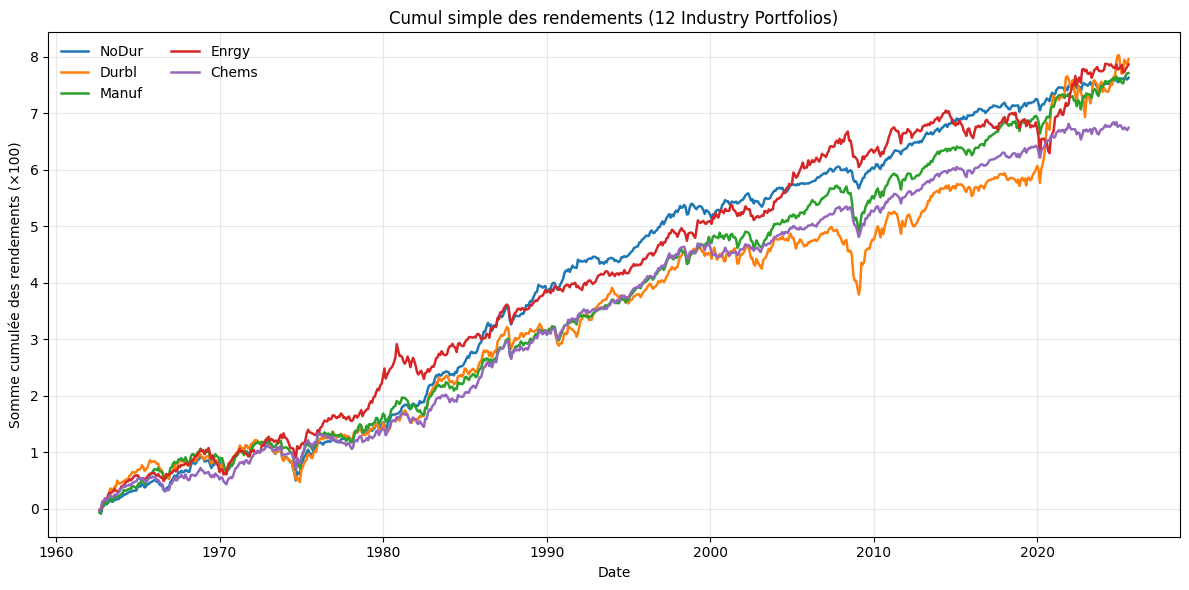

In [597]:
plt.figure(figsize=(12,6))
for c in indus_cum.columns[:5]:
    plt.plot(indus_cum.index, indus_cum[c], label=c, lw=1.8)

plt.title("Cumul simple des rendements (12 Industry Portfolios)")
plt.xlabel("Date")
plt.ylabel("Somme cumulée des rendements (×100)")
plt.legend(ncol=2, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Données facteurs

In [598]:
# Fama-French 5 + Momentum (MKT, SMB, HML, RMW, CMA, MOM)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5 = pd.read_csv(url, skiprows=3)

# Nettoyage colonnes + filtre des lignes AAAAMM
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})
ff5.columns = ff5.columns.str.strip()
ff5 = ff5[ff5["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m")
ff5 = ff5.set_index("Date")
ff5  = ff5.astype(float) / 100  

# --- MOM (Momentum) ---
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
mom = pd.read_csv(url_mom, skiprows=13)

# Nettoyage noms de colonnes et de la colonne Date
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom.columns = mom.columns.str.strip()

# Garder uniquement les lignes AAAAMM (et ignorer les NaN dans le masque)
mom = mom[mom["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Index temps + numérisation
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
# Convertir toutes les colonnes en float, puis en proportions
mom = mom.set_index("Date")
mom = mom.apply(pd.to_numeric, errors="coerce") / 100

# Renommer proprement la colonne momentum (souvent "Mom" avec espaces)
mom.columns = mom.columns.str.strip()
mom = mom.rename(columns={mom.columns[0]: "MOM"})  # sécurise quel que soit l'intitulé

# --- Merge ---
ff_factors = ff5.join(mom[["MOM"]], how="inner")
print(ff_factors.tail())

            Mkt-RF     SMB     HML     RMW     CMA      RF     MOM
Date                                                              
2025-05-01  0.0606 -0.0072 -0.0288  0.0129  0.0251  0.0038  0.0221
2025-06-01  0.0486 -0.0002 -0.0160 -0.0320  0.0145  0.0034 -0.0264
2025-07-01  0.0198 -0.0015 -0.0127 -0.0029 -0.0208  0.0034 -0.0096
2025-08-01  0.0185  0.0488  0.0442 -0.0068  0.0207  0.0038 -0.0354
2025-09-01  0.0339 -0.0218 -0.0105 -0.0203 -0.0222  0.0033  0.0466


In [599]:

# # 1️⃣ Créer le marché total (ETF-like)
# ff_factors["MKT"] = ff_factors["Mkt-RF"] + ff_factors["RF"]

# # # 2️⃣ Sélectionner les colonnes de facteurs à tracer
# # factor_cols = ["MKT", "SMB", "HML", "RMW", "CMA", "MOM"]

# # 3️⃣ Sous-échantillon à partir de 2016
# ff_sub = ff_factors.loc["1999-01-01":, :]

# # 4️⃣ Calculer les performances cumulées
# ff_cum = (1 + ff_sub).cumprod() - 1

# # 5️⃣ Plot
# plt.figure(figsize=(12,6))
# palette = sns.color_palette("tab10", n_colors=len(factor_cols))

# for i, col in enumerate(factor_cols):
#     plt.plot(ff_cum.index, ff_cum[col], label=col, lw=2, color=palette[i])

# plt.title("Performance cumulée des facteurs Fama–French + MOM (depuis 2016)",
#           fontsize=13, weight="bold")
# plt.xlabel("Date")
# plt.ylabel("Rendement cumulé")
# plt.grid(alpha=0.3)
# plt.legend(frameon=False, ncol=3)
# plt.tight_layout()
# plt.show()

## Unsupervised

Composantes retenues : 35
Variance expliquée cumulée : 85.37%


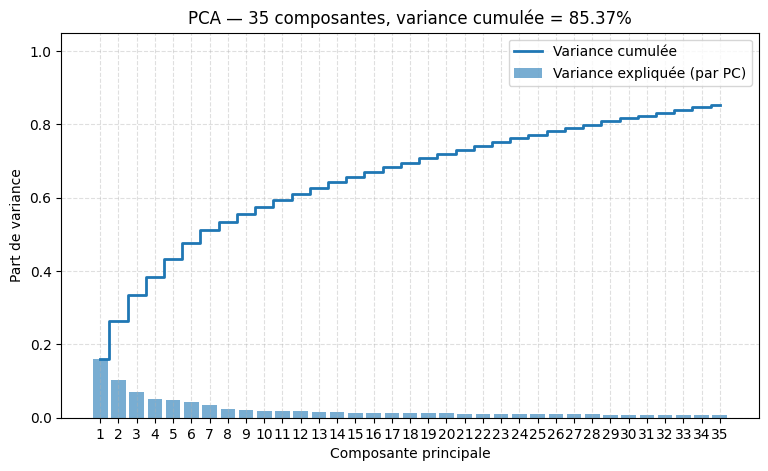

In [600]:
# ============================================
# PCA (fit sur TRAIN) puis projection du TEST
# ============================================

# Hypothèses :
# - train_std et test_std existent déjà (standardisés AVEC LE MÊME scaler : fit sur train, transform sur test)

pca = PCA(n_components=0.85, svd_solver='full')

# --- Fit sur TRAIN ---
X_pca_train = pd.DataFrame(
    pca.fit_transform(train_std),
    index=train_std.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print(f"Composantes retenues : {pca.n_components_}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")

# --- Transform du TEST (projection OOS dans l'espace PCA IS) ---
X_pca_test = pd.DataFrame(
    pca.transform(test_std),
    index=test_std.index,
    columns=X_pca_train.columns
)

# (optionnel) concat pour avoir toute la série dans le même repère PCA
X_pca_all = pd.concat([X_pca_train, X_pca_test]).sort_index()

# ============================================
# Plot variance expliquée (sur train)
# ============================================

evr = pca.explained_variance_ratio_
evr_cum = np.cumsum(evr)
k = pca.n_components_

plt.figure(figsize=(9, 5))
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Variance expliquée (par PC)')
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0, label='Variance cumulée')

plt.xlabel('Composante principale')
plt.ylabel('Part de variance')
plt.title(f'PCA — {k} composantes, variance cumulée = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()



=== Critères par k (TRAIN) ===
      loglik           AIC           BIC        ENT           ICL
k                                                                
6 -58.104234  75338.939685  77235.727204 -78.181115  77392.089435
3 -59.364522  76529.267292  77475.429537 -36.872451  77549.174438
5 -58.590712  75820.901018  77400.813445 -80.716525  77562.246496
4 -58.951310  76140.992976  77404.030312 -88.011969  77580.054251
2 -59.877280  77044.421127  77673.708280 -33.377381  77740.463042


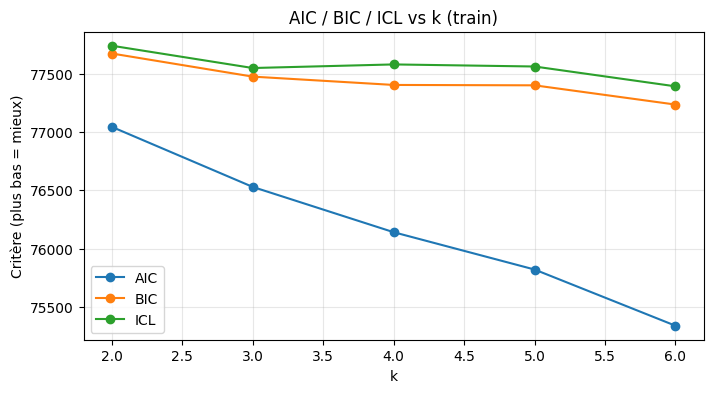

In [601]:
# === 1) Calcule et affiche les critères pour k in [2..5] ===
k_candidates = range(2, 7)
rows = []
models = {}

for k_ in k_candidates:
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_pca_train)

    bic = g.bic(X_pca_train)
    aic = g.aic(X_pca_train)
    tau = np.clip(g.predict_proba(X_pca_train), 1e-12, 1.0)
    ent = (tau * np.log(tau)).sum()          # ENT <= 0
    icl = bic - 2.0 * ent                    # ICL à minimiser

    rows.append({"k": k_, "loglik": g.lower_bound_, "AIC": aic, "BIC": bic, "ENT": ent, "ICL": icl})
    models[k_] = g

ic_df = pd.DataFrame(rows).set_index("k")
print("\n=== Critères par k (TRAIN) ===")
print(ic_df.sort_values("ICL"))

# (optionnel) petit plot pour t’aider à choisir
plt.figure(figsize=(8,4))
for col in ["AIC","BIC","ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("k"); plt.ylabel("Critère (plus bas = mieux)")
plt.title("AIC / BIC / ICL vs k (train)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# === 2) Choix manuel du nombre de régimes ===
chosen_k = 6  # <-- mets la valeur que TU veux
gmm = models[chosen_k]

# Sécurité : si tu préfères refitter proprement (mêmes hyperparams) :
# gmm = GaussianMixture(n_components=chosen_k, covariance_type="diag",
#                       n_init=10, reg_covar=1e-6, random_state=42).fit(X_pca_train)

if hasattr(gmm, "converged_") and not gmm.converged_:
    print("GMM non convergé.")

# === 3) Prédictions (train) ===
labels_tr = gmm.predict(X_pca_train)
probas_tr = gmm.predict_proba(X_pca_train)
llk_tr    = gmm.score_samples(X_pca_train)

# construit la série indexée pour tes plots
dates_train = X_pca_train.index
gmm_labels = pd.Series(labels_tr, index=dates_train, name="gmm_label").astype(int)


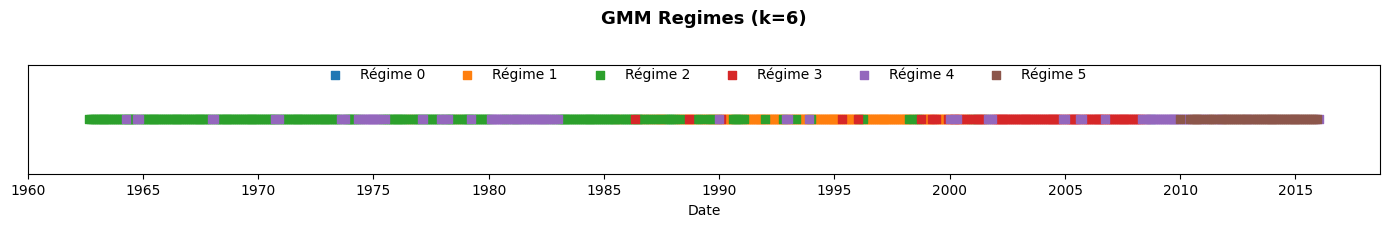

In [602]:
# --- Données : extraire les labels et l'index temps ---
dates = gmm_labels.index

# --- Palette cohérente ---
n_regimes = gmm_labels.max() + 1
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold")

# Plot des points colorés (timeline horizontale)
for k_ in range(n_regimes):
    idx_k = gmm_labels[gmm_labels == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_], label=f"Régime {k_}", marker="s")


# Mise en forme
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

# Légende centrée
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=n_regimes,
    frameon=False
)

ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold", pad=30)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=n_regimes, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...
Outliers détectés (OCSVM) : 51 sur 641 observations (8.0%).
Étape 2 : K-means cosinus sur les mois typiques (PCA)...


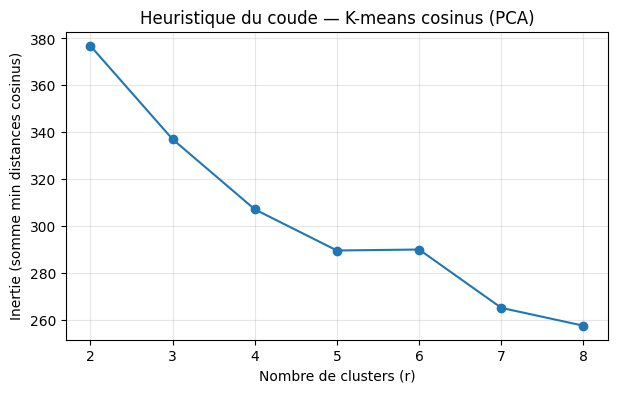

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus terminé.
Étape 3 : Calcul des distributions de probabilité...
Étape 4 : Calcul de la matrice de transition...
Matrice de transition P(i→j) :
       0      1      2      3      4      5
0  0.275  0.255  0.098  0.059  0.176  0.137
1  0.162  0.505  0.091  0.051  0.051  0.141
2  0.037  0.075  0.851  0.030  0.000  0.007
3  0.019  0.046  0.037  0.898  0.000  0.000
4  0.065  0.057  0.000  0.000  0.805  0.073
5  0.048  0.112  0.016  0.000  0.072  0.752


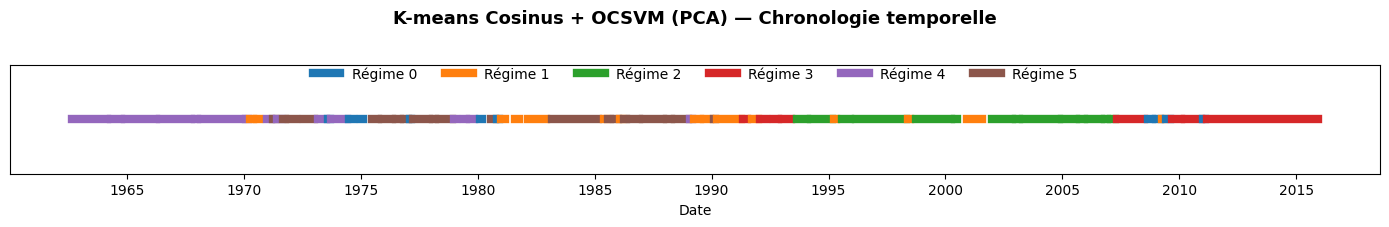

In [603]:
# ============================================
# K-MEANS REGIME DETECTION — VERSION PCA + OCSVM (FIDÈLE AUTEURS)
# ============================================

# ----------------------------------------------------
# 1. Détection des outliers via One-Class SVM
# ----------------------------------------------------
print("Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...")

# ν = fraction maximale d'outliers (ex: 0.02 = 2%)
ocs = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale").fit(X_pca_train)
is_outlier = ocs.predict(X_pca_train) == -1
decision_scores = ocs.decision_function(X_pca_train)  # plus petit = plus anormal

# Convertir scores en probabilité approchée (sigmoïde)
from scipy.special import expit
p_reg0 = 1 - expit((decision_scores - np.min(decision_scores)) / (np.std(decision_scores) + 1e-8))

X_typical = X_pca_train.loc[~is_outlier]
dates_typical = X_typical.index
print(f"Outliers détectés (OCSVM) : {is_outlier.sum()} sur {len(X_pca_train)} observations ({100*is_outlier.mean():.1f}%).")

# ----------------------------------------------------
# 2. Vrai K-means Cosinus sur les mois typiques
# ----------------------------------------------------
print("Étape 2 : K-means cosinus sur les mois typiques (PCA)...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    X = normalize(X, norm='l2')  # chaque observation sur la sphère unité
    n, d = X.shape

    centers = X[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for it in range(max_iter):
        sim = X @ centers.T
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = normalize(cluster_points.mean(axis=0).reshape(1, -1))
            else:
                new_centers[j] = centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break
    dist_cos = 1 - (X @ centers.T)
    return labels, centers, dist_cos

# --- Détermination du nombre optimal r
inertias = []
k_range = range(2, 9)
X_typical_np = X_typical.values
for k_ in k_range:
    labels, centers, dist_cos = spherical_kmeans(X_typical_np, k_)
    inertia = np.sum(np.min(dist_cos, axis=1))
    inertias.append(inertia)

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # ajuster selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels, cos_centers, cos_dists = spherical_kmeans(X_typical_np, r)
print("Clustering cosinus terminé.")

# ----------------------------------------------------
# 3. Distributions de probabilité (Éqs. 1 et 4)
# ----------------------------------------------------
print("Étape 3 : Calcul des distributions de probabilité...")

cos_probs = 1 - (cos_dists / cos_dists.sum(axis=1, keepdims=True))
cos_probs = cos_probs / cos_probs.sum(axis=1, keepdims=True)

final_probs = pd.DataFrame(index=dates, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs.loc[:, :] = 0.0

Pm = np.max(cos_probs, axis=1)
P0 = p_reg0[~is_outlier]

# Éq. (4) : P_R0 = - Pm * log2(1 - P(Regime 0))
PR0 = -Pm * np.log2(1 - P0)
PR0[np.isnan(PR0)] = 0.0
PR0[PR0 < 0] = 0.0

final_probs.loc[dates_typical, "Regime_0"] = PR0
for j in range(r):
    final_probs.loc[dates_typical, f"Regime_{j+1}"] = cos_probs[:, j]

final_probs.loc[dates[is_outlier], "Regime_0"] = 1.0
final_probs = final_probs.div(final_probs.sum(axis=1), axis=0)

hard_labels = final_probs.idxmax(axis=1).str.extract("(\d+)").astype(int).values.flatten()

# ----------------------------------------------------
# 4. Matrice de transition (Éq. 5)
# ----------------------------------------------------
print("Étape 4 : Calcul de la matrice de transition...")

ordered_labels = pd.Series(hard_labels, index=dates).sort_index()
regimes = np.unique(hard_labels)
transition_matrix = pd.DataFrame(0.0, index=regimes, columns=regimes)

for i in range(len(ordered_labels)-1):
    i_reg = ordered_labels.iloc[i]
    j_reg = ordered_labels.iloc[i+1]
    transition_matrix.loc[i_reg, j_reg] += 1

transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
print("Matrice de transition P(i→j) :")
print(transition_matrix.round(3))

# ----------------------------------------------------
# 5. Visualisation temporelle
# ----------------------------------------------------
# --- Nettoyage et paramétrage ---
res_kmeans = pd.DataFrame({"kmeans_label": hard_labels}, index=dates).sort_index()
palette = sns.color_palette("tab10", n_colors=res_kmeans["kmeans_label"].nunique())

fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title("K-means Cosinus + OCSVM (PCA) — Chronologie temporelle", fontsize=13, weight="bold", pad=30)

# --- Construction de segments (blocs continus) ---
labels = res_kmeans["kmeans_label"].values
times = res_kmeans.index

start_idx = 0
for i in range(1, len(labels)):
    if labels[i] != labels[i-1] or i == len(labels)-1:
        ax.plot(times[start_idx:i], [0]* (i-start_idx), 
                color=palette[labels[i-1]], lw=6)
        start_idx = i

# --- Mise en forme ---
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.legend(
    handles=[plt.Line2D([0], [0], color=palette[k], lw=6, label=f"Régime {k}") 
             for k in sorted(res_kmeans["kmeans_label"].unique())],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=res_kmeans["kmeans_label"].nunique(),
    frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Supervised

In [604]:
# ---------------------------
# 1) Construire X,y (IS) pour prédire regime_{t+1}
# ---------------------------
# gmm_labels : Series (index = dates_train), labels sur TRAIN (à t)
# On veut y_t = label_{t+1}
y_train = gmm_labels.shift(-1).dropna().astype(int)

# Aligner X sur y (même index)
X_train_super = X_pca_train.loc[y_train.index]

# Sanity check dimensions
assert len(X_train_super) == len(y_train)

tscv = TimeSeriesSplit(n_splits=5)
best_C, best_score = None, -np.inf
# ---------------------------
# 2) Validation temporelle simple (expanding split)
# ---------------------------

for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    scores = []
    for tr_idx, va_idx in tscv.split(X_train_super):
        Xtr, Xva = X_train_super.iloc[tr_idx], X_train_super.iloc[va_idx]
        ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        clf = LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=C,
            class_weight="balanced",
            max_iter=200
        )
        clf.fit(Xtr, ytr)
        pva = clf.predict_proba(Xva)

        # garder seulement les points de validation dont la classe est connue du modèle
        mask = yva.isin(clf.classes_)
        if mask.sum() == 0:
            continue  # aucun point évaluable dans ce split

        yva_f = yva[mask]
        pva_f = pva[mask.values, :]  # aligner les proba sur les indices valides

        score = -log_loss(yva_f, pva_f, labels=clf.classes_)
        scores.append(score)

    # moyenne sur les splits
    if len(scores) > 0:
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score, best_C = mean_score, C

print(f"Meilleur C (CV): {best_C:.2f}  |  score CV (−logloss): {best_score:.4f}")

# ---------------------------
# 3) Fit final sur tout l'IS avec le meilleur C
# ---------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=best_C,
    class_weight="balanced",
    max_iter=500
)
clf.fit(X_train_super, y_train)

# (diagnostics IS)
yhat_is = clf.predict(X_train_super)
p_is = clf.predict_proba(X_train_super)
print("Balanced Acc (IS):", balanced_accuracy_score(y_train, yhat_is))
print("Macro-F1 (IS):", f1_score(y_train, yhat_is, average="macro"))

# ---------------------------
# 4) Inférence OOS (t -> t+1) sur X_pca_test
# ---------------------------
# Attention: on ne connaît pas y_test (pas de labels OOS) → on sort des PROBAS
p_test = pd.DataFrame(
    clf.predict_proba(X_pca_test),
    index=X_pca_test.index,
    columns=[f"reg_{k}" for k in clf.classes_]
)

# label "dur" (si tu veux visualiser) = argmax
yhat_oos_hard = p_test.values.argmax(axis=1)
yhat_oos_hard = pd.Series(yhat_oos_hard, index=p_test.index, name="regime_pred_hard")

# ---------------------------
# 5) (Option) Hystérésis / persistance minimale sur les probas
# ---------------------------
def apply_hysteresis(prob_df, enter=0.65, exit_=0.55, min_len=3):
    classes = prob_df.columns
    state_series = []
    cur_state, run_len = None, 0

    for t, row in prob_df.iterrows():
        pmax = row.max()
        smax = row.idxmax()  # string 'reg_k'
        kmax = int(smax.split("_")[-1])

        if cur_state is None:
            # entrer si assez confiant
            cur_state = kmax if pmax >= enter else kmax  # ou None si tu veux du 'no-position'
            run_len = 1
        else:
            if kmax == cur_state:
                run_len += 1
            else:
                # quitter seulement si perte de confiance + durée min atteinte
                if (pmax >= enter) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                elif (row[f"reg_{cur_state}"] < exit_) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                else:
                    run_len += 1  # maintenir

        state_series.append(cur_state)

    return pd.Series(state_series, index=prob_df.index, name="regime_pred_smooth")

yhat_oos_smooth = apply_hysteresis(p_test, enter=0.65, exit_=0.55, min_len=3)

# ---------------------------
# 6) (Option) Mapping économique des états
# ---------------------------
# Si tu as défini sur IS un mapping 'éco' (ex: crise=vol SPX max), applique-le ici
# map_dict = {old_label: new_label}  # ex: {2:1, 0:0, 3:2, ...}
# yhat_oos_smooth = yhat_oos_smooth.map(map_dict)

# ---------------------------
# 7) (Option) Sauvegarde des sorties pour backtest
# ---------------------------
supervised_out = pd.concat([p_test, yhat_oos_hard, yhat_oos_smooth], axis=1)
print(supervised_out.head())


c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\

Meilleur C (CV): 0.10  |  score CV (−logloss): -1.6251
Balanced Acc (IS): 0.8783363329802442
Macro-F1 (IS): 0.8664317852702977
               reg_0     reg_1     reg_2     reg_3     reg_4     reg_5  \
sasdate                                                                  
2016-01-01  0.000510  0.058259  0.003332  0.055532  0.005217  0.877150   
2016-02-01  0.001820  0.122878  0.008292  0.375157  0.222116  0.269737   
2016-03-01  0.000680  0.028999  0.001745  0.089110  0.011894  0.867571   
2016-04-01  0.000530  0.062931  0.005499  0.032865  0.013745  0.884431   
2016-05-01  0.000141  0.019304  0.000287  0.013447  0.002208  0.964613   

            regime_pred_hard  regime_pred_smooth  
sasdate                                           
2016-01-01                 5                   5  
2016-02-01                 3                   5  
2016-03-01                 5                   5  
2016-04-01                 5                   5  
2016-05-01                 5                   5

c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


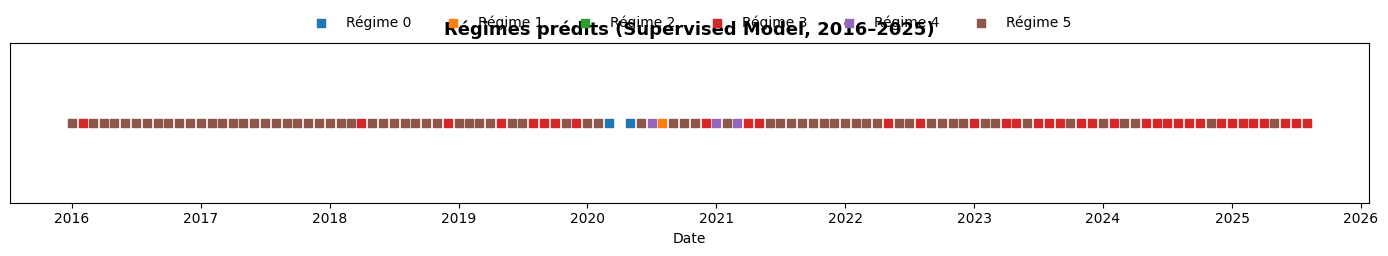

In [605]:
# ------------------------------------------------------------
reg_cols = [c for c in supervised_out.columns if c.startswith("reg_")]

gmm_labels_oos = (
    supervised_out.loc["2016-01-01":, reg_cols]
    .idxmax(axis=1)
    .str.extract(r"(\d+)").astype(int)[0]
    .rename("regime_pred")
)

dates_oos = gmm_labels_oos.index
n_regimes = gmm_labels_oos.max() + 1

# ------------------------------------------------------------
# 2) Palette + Figure
# ------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=n_regimes)

fig, ax = plt.subplots(figsize=(14, 2.8))
ax.set_title(f"Régimes prédits (Supervised Model, 2016–{dates_oos[-1].year})",
             fontsize=13, weight="bold")

# Timeline colorée (même style que GMM)
for k_ in range(n_regimes):
    idx_k = gmm_labels_oos[gmm_labels_oos == k_].index
    ax.scatter(idx_k, [0]*len(idx_k),
               s=35, color=palette[k_],
               label=f"Régime {k_}", marker="s")

# ------------------------------------------------------------
# 3) Mise en forme
# ------------------------------------------------------------
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=min(6, n_regimes),
    frameon=False
)

plt.tight_layout()
plt.show()


In [606]:
print(gmm_labels_oos)

sasdate
2016-01-01    5
2016-02-01    3
2016-03-01    5
2016-04-01    5
2016-05-01    5
             ..
2025-04-01    3
2025-05-01    5
2025-06-01    3
2025-07-01    3
2025-08-01    3
Name: regime_pred, Length: 115, dtype: int64


## Construction de portefeuille

Pour rappel on liste les df utiles :

In [607]:
# indus_cum : dataframe des rendements industry cumulés 
# res_kmeans : dataframe résultats kmeans regime detection avant 2016 IS
#  indus_df : dataframe des rendements industry bruts 

# indus_IS : dataframe des rendements industry bruts IS 
# indus_OOS : dataframe des rendements industry bruts OOS

indus_IS.head()


,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1962-09-01,-5.61,-2.20,-7.13,-1.77,-3.21,-9.37,-6.06,-2.87,-6.63,-4.05,-5.69,-5.81
1962-10-01,-3.27,2.46,-0.20,-0.29,4.26,0.01,2.77,-1.09,-1.34,2.46,-0.74,1.46
1962-11-01,12.12,6.82,13.85,10.75,12.10,14.82,7.17,7.65,11.16,17.63,14.09,15.25
1962-12-01,1.45,3.54,-1.72,4.69,0.84,-0.70,1.08,3.48,0.04,0.88,1.66,1.21
1963-01-01,5.94,7.60,6.14,2.68,4.62,6.11,4.13,5.25,4.13,5.66,3.60,6.29


### Calcul des moments conditionnels

In [608]:
def conditional_moments(
    returns_df: pd.DataFrame,
    regimes_df: pd.DataFrame,
    label_col: str = "kmeans_label",
    cols: list[str] | None = None,
    min_obs: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[int, pd.DataFrame], pd.Series]:
    """
    Calcule E[R | régime], Std[R | régime], Cov[R | régime] avec alignement robuste des dates.
    
    Params
    ------
    returns_df : DataFrame
        Rendements (en proportions) indexés par Date.
    regimes_df : DataFrame
        Doit contenir une colonne `label_col` indexée par Date (mêmes unités temporelles).
    label_col : str
        Nom de la colonne contenant le label de régime.
    cols : list[str] | None
        Sous-ensemble de colonnes de returns à utiliser. Si None -> colonnes numériques.
    min_obs : int
        Nombre minimal d'observations par régime (sinon le régime est ignoré).

    Returns
    -------
    mean_df : DataFrame     # moyennes conditionnelles par régime
    std_df  : DataFrame     # écarts-types conditionnels par régime
    covs    : dict[int, DataFrame]  # matrices de covariance par régime
    n_by_regime : Series    # effectif par régime (après filtre)
    """

    # 1) Alignement des dates (intersection) en démarrant à la date commune la plus récente
    r0, g0 = returns_df.sort_index(), regimes_df.sort_index()
    start = max(r0.index.min(), g0.index.min())
    r1 = r0.loc[start:]
    g1 = g0.loc[start:]
    df = r1.join(g1[[label_col]], how="inner").dropna(subset=[label_col])

    # 2) Colonnes à utiliser
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop(label_col, errors="ignore")
    else:
        cols = pd.Index(cols).intersection(df.columns)

    # 3) Groupby et moments
    groups = dict(tuple(df.groupby(label_col)))
    means, stds, covs, counts = {}, {}, {}, {}
    for reg, sub in groups.items():
        subX = sub[cols].dropna(how="any")
        n = len(subX)
        if n >= min_obs:
            means[reg] = subX.mean()
            stds[reg]  = subX.std(ddof=1)
            covs[reg]  = subX.cov()
            counts[reg]= n

    # 4) Assemblage
    mean_df = pd.DataFrame(means).T.sort_index()
    std_df  = pd.DataFrame(stds).T.sort_index()
    n_by_regime = pd.Series(counts).sort_index()

    return mean_df, std_df, covs, n_by_regime


In [611]:
# Vérification de l'alignement temporel
print("Période industries :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Période régimes   :", res_kmeans.index.min(), "→", res_kmeans.index.max())

# Appel de la fonction généralisée
mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS = conditional_moments(
    returns_df = indus_IS,     # rendements bruts industries
    regimes_df = res_kmeans,    # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime ===")
print(mean_ind_IS.round(4))
print("\n=== Volatilités conditionnelles ===")
print(std_ind_IS.round(4))
print("\n=== Effectif par régime ===")
print(n_ind_IS)

# Exemple : covariance du régime 0
print("\n=== Covariance régime 0 ===")
print(cov_ind_IS[0].round(4))

print(mean_ind_IS.head())


Période industries : 1962-09-01 00:00:00 → 2016-01-01 00:00:00
Période régimes   : 1962-09-01 00:00:00 → 2016-01-01 00:00:00
=== Moyennes conditionnelles par régime ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm   Utils   Shops  \
0 -0.2069 -0.8922 -0.7122  0.0612 -0.2153 -0.3837 -0.4063  0.0641 -0.1788   
1  2.4842  1.7624  1.6711  1.3086  1.6799  1.2823  1.5583  1.9092  2.3292   
2  0.8719  0.6802  1.2582  1.2500  0.9733  1.2847  0.7505  0.7878  0.9203   
3  0.9144  1.0021  0.8897  0.5501  1.0587  0.9761  1.0230  0.8639  1.0161   
4  0.8267  0.8311  0.9837  1.1004  0.7537  1.1281  0.5154  0.3282  0.8670   
5  1.1435  0.9747  0.8808  1.3102  0.7965  0.8130  1.1426  0.8032  0.8313   

     Hlth   Money   Other  
0 -0.1308 -0.5294 -0.7149  
1  2.4363  2.3264  1.6249  
2  1.0385  1.1474  0.5616  
3  0.8333  0.4969  0.7239  
4  1.3605  0.9492  1.2203  
5  0.5464  0.6666  0.9070  

=== Volatilités conditionnelles ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm 

In [610]:
# Si tu as déjà un DataFrame des régimes in-sample :
# res_kmeans  (index = dates, colonne 'kmeans_label')

mean_IS, std_IS, cov_IS = conditional_moments(ff_factors, res_kmeans)

print(mean_IS.round(4).head())
print(std_IS.round(4).head())
# Exemple: afficher la covariance du régime 0 (ou 1 selon tes labels)
print(cov_IS[sorted(cov_IS.keys())[0]].round(4))


ValueError: too many values to unpack (expected 3)

In [ ]:
mean_df, std_df, covs = conditional_moments(ff_factors, res_kmeans)

print("E[R | régime] :")
print(mean_df.round(4))

print("\nVolatilité (écart-type) par régime :")
print(std_df.round(4))

# Exemple : matrice de covariance du régime 1
print("\nCovariance (régime 1) :")
print(covs[1].round(4))


E[R | régime] :
   Mkt-RF     SMB     HML     RMW     CMA      RF     MOM
0 -0.0092 -0.0010  0.0058  0.0003  0.0066  0.0047 -0.0007
1  0.0117  0.0027  0.0030  0.0049  0.0036  0.0057  0.0031
2  0.0066  0.0017  0.0037  0.0025  0.0038  0.0031  0.0080
3  0.0070 -0.0001 -0.0004  0.0028  0.0006  0.0010  0.0091
4  0.0032  0.0059  0.0044  0.0000  0.0020  0.0046  0.0116
5  0.0034  0.0034  0.0053  0.0040  0.0032  0.0054  0.0062

Volatilité (écart-type) par régime :
   Mkt-RF     SMB     HML     RMW     CMA      RF     MOM
0  0.0664  0.0327  0.0379  0.0215  0.0200  0.0036  0.0576
1  0.0518  0.0314  0.0327  0.0228  0.0246  0.0027  0.0621
2  0.0395  0.0361  0.0298  0.0339  0.0221  0.0014  0.0424
3  0.0374  0.0225  0.0227  0.0159  0.0138  0.0015  0.0318
4  0.0362  0.0314  0.0211  0.0173  0.0202  0.0019  0.0344
5  0.0439  0.0267  0.0254  0.0138  0.0167  0.0016  0.0273

Covariance (régime 1) :
        Mkt-RF     SMB     HML     RMW     CMA   RF     MOM
Mkt-RF  0.0027  0.0001 -0.0010 -0.0003 -0.0008 -0

### Construction de portefeuille

In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS : df des moments inconditionnels IS industries
# gmm_labels_oos : régime OSS pour le moment

In [612]:
import numpy as np
import pandas as pd

# --- portefeuilles élémentaires ---
def min_var_portfolio(mu: pd.Series, cov: pd.DataFrame) -> pd.Series:
    inv = np.linalg.inv(cov.values)
    one = np.ones(len(mu))
    w = inv @ one / (one @ inv @ one)
    return pd.Series(w, index=mu.index)

def tangency_portfolio(mu: pd.Series, cov: pd.DataFrame, rf: float = 0.0) -> pd.Series:
    inv = np.linalg.inv(cov.values)
    w = inv @ (mu.values - rf)
    w = w / w.sum()
    return pd.Series(w, index=mu.index)

# --- moteur général ---
def regime_markowitz_backtest(
    returns_oos: pd.DataFrame,          # rendements OOS à trader (colonnes = actifs/industries, en proportions)
    regimes_oos: pd.Series,             # gmm_labels_oos (index = dates), entiers 0..K-1
    mean_IS: pd.DataFrame,              # moyennes conditionnelles IS (index = régimes, colonnes = mêmes actifs)
    cov_IS: dict,                       # covariances conditionnelles IS {regime: DataFrame}
    method: str = "tangency",           # "tangency" ou "minvar"
    rf: float = 0.0,                    # rf pour tangence
    shift_horizon: int = 1              # appliquer w(t) à R(t+1) pour éviter look-ahead
):
    # 0) hygiène
    regimes_oos = regimes_oos.copy()
    if not isinstance(regimes_oos, pd.Series):
        regimes_oos = pd.Series(regimes_oos)
    regimes_oos.index = pd.to_datetime(regimes_oos.index)
    returns_oos = returns_oos.copy()
    returns_oos.index = pd.to_datetime(returns_oos.index)

    # 1) portefeuilles par régime (IS)
    maker = (lambda mu, C: tangency_portfolio(mu, C, rf)) if method == "tangency" else (lambda mu, C: min_var_portfolio(mu, C))
    # gardez seulement les régimes présents des deux côtés
    usable_regs = sorted(set(mean_IS.index).intersection(cov_IS.keys()))
    weight_by_regime = {k: maker(mean_IS.loc[k], cov_IS[k]).reindex(returns_oos.columns).fillna(0.0)
                        for k in usable_regs}

    # 2) mapping des régimes OOS -> poids
    weights_oos = regimes_oos.map(weight_by_regime)           # Series of Series
    # si un régime OOS n’existe pas en IS, on met 0
    weights_oos = weights_oos.apply(lambda s: s if isinstance(s, pd.Series) else pd.Series(0.0, index=returns_oos.columns))
    weights_oos = pd.DataFrame(weights_oos.tolist(), index=regimes_oos.index).reindex(columns=returns_oos.columns, fill_value=0.0)

    # 3) retours de la stratégie (look-ahead safe)
    aligned_ret = returns_oos.loc[weights_oos.index]
    port_ret_oos = (weights_oos.shift(shift_horizon) * aligned_ret).sum(axis=1).dropna()

    # 4) stats rapides
    mu_p  = port_ret_oos.mean()
    sig_p = port_ret_oos.std(ddof=1)
    sharpe = mu_p / sig_p if sig_p and sig_p > 0 else np.nan
    stats = {"mean": mu_p, "vol": sig_p, "sharpe": sharpe}

    return weights_oos, port_ret_oos, stats


In [621]:
indus_OOS.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2016-01-01,0.17,-12.33,-6.25,-4.37,-4.71,-5.94,0.39,4.67,-4.53,-10.12,-9.72,-6.96
2016-02-01,0.59,4.09,3.65,-2.95,2.65,-0.88,0.91,1.72,0.11,-0.97,-3.01,4.05
2016-03-01,4.96,10.65,7.35,10.89,6.14,8.51,6.16,7.84,5.56,3.95,6.60,7.99
2016-04-01,0.27,1.54,2.63,9.17,1.68,-4.25,0.69,-0.80,-0.55,4.96,4.16,-0.34
2016-05-01,0.74,-1.09,-0.59,-0.59,-0.42,5.17,0.17,2.24,0.96,2.42,2.20,-0.46


In [623]:
# rendements OOS à trader (ex: industries OOS, en proportions)
returns_oos = indus_OOS.copy()                      # DataFrame, colonnes = industries

# régimes OOS (labels prédits)
regimes_oos = gmm_labels_oos.copy()                 # Series d'entiers, index = dates

# moments IS (déjà calculés sur industries)
mean_IS = mean_ind_IS.copy()
cov_IS  = cov_ind_IS.copy()

# hygiène: même colonnes partout
returns_oos = returns_oos.reindex(columns=mean_IS.columns)
print(regimes_oos.info())   


<class 'pandas.core.series.Series'>
DatetimeIndex: 115 entries, 2016-01-01 to 2025-08-01
Series name: regime_pred
Non-Null Count  Dtype
--------------  -----
115 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB
None


In [ ]:
regimes_oos = regimes_oos.astype(int)

# Colonnes de référence (mêmes actifs que returns_oos)
cols = list(returns_oos.columns)

# Série de poids par régime, avec fallback = 0 si régime inconnu
zero_w = pd.Series(0.0, index=cols)

weights_list = [
    weight_by_regime.get(k, zero_w)       # k = label de régime à cette date
    for k in regimes_oos.values
]

weights_oos = pd.DataFrame(weights_list, index=regimes_oos.index).reindex(columns=cols, fill_value=0.0)
print(weights_oos.head())


            NoDur  Durbl  Manuf  Enrgy  Chems  BusEq  Telcm  Utils  Shops  \
sasdate                                                                     
2016-01-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-02-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-03-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-04-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2016-05-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            Hlth  Money  Other  
sasdate                         
2016-01-01   0.0    0.0    0.0  
2016-02-01   0.0    0.0    0.0  
2016-03-01   0.0    0.0    0.0  
2016-04-01   0.0    0.0    0.0  
2016-05-01   0.0    0.0    0.0  


In [618]:
aligned_ret = returns_oos.loc[weights_oos.index]
port_ret_oos = (weights_oos.shift(1) * aligned_ret).sum(axis=1).dropna()

mu_p  = port_ret_oos.mean()
sig_p = port_ret_oos.std(ddof=1)
sharpe = mu_p / sig_p if sig_p > 0 else np.nan
print(f"OOS mean={mu_p:.4f}  vol={sig_p:.4f}  Sharpe={sharpe:.2f}")


OOS mean=0.0000  vol=0.0000  Sharpe=nan
